In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class scaledDotProduct(nn.Module):
    '''
        Attention(Q, K, V ) = softmax( QK^T/√d_k)V 
    
    '''
    def __init__(self, dim, drop=0.0):
        super(scaledDotProduct, self).__init__()
        #dim is (d_k) when sqrt'd it is meant to counter small gradients in large sets of queries and keys
        self.d_k = np.sqrt(dim)
        #Simple drop out 
        self.drop = nn.Dropout(drop)

    def forward(self, q, k, v, mask=None):
        #first two dimensions are batch and number of heads?
        n = torch.matmul(q, k.transpose(2,3)) / self.d_k

        if mask != None:
            n = n.masked_fill_(mask==0, -1e9)
        #Drop out referenced later in paper but not in original diagram
        att = self.drop(F.softmax(n, -1))

        out = torch.matmul(n, v)

        return out, att 
        
        


In [3]:
#Scaled dot product attention testing
#dim should be size of q and k
scaled_dot = scaledDotProduct(3)
q = torch.rand(1,1,2,3)
k = torch.rand(1,1,2,3)
v = torch.rand(1,1,2,4)


scaled_dot(q,k,v)

(tensor([[[[0.7753, 0.6551, 0.7155, 0.4428],
           [0.8353, 0.7215, 0.7672, 0.4609]]]]),
 tensor([[[[0.4364, 0.5636],
           [0.4188, 0.5812]]]]))

In [4]:
class multiHeadedAttention(nn.Module):
    def __init__(self, n_heads, dims, d_k, d_v, dropout=0.0):
        super(multiHeadedAttention, self).__init__()
        #d_k=d_v = dims/h

        self.n_heads = n_heads
        self.d_k = d_k
        self.d_v = d_v
        #Pre-attention projection matrices
        self.w_q = nn.Linear(dims, n_heads * d_k, bias=False)
        self.w_k = nn.Linear(dims, n_heads * d_k, bias=False)
        self.w_v = nn.Linear(dims, n_heads * d_v, bias=False)

        self.att = scaledDotProduct(d_k)
        #Final linear layer after concat and attention
        self.fc = nn.Linear(n_heads*d_v, dims)

        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(dims,eps=1e-6)

    def forward(self, q, k, v, mask=None):
        d_k, d_v, heads = self.d_k, self.d_v, self.n_heads
        batch_len, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        res = q

        #Pass through projection layers prior to attention layer batch x length of query x (nheads x value dimensionality)
        #View as batches x len of query x numbers of heads x dimensionality to sperate out heads dimension
        #print(q.shape)
        q = self.w_q(q).view(batch_len, len_q, heads, d_k)
        k = self.w_k(k).view(batch_len, len_k, heads, d_k)
        v = self.w_v(v).view(batch_len, len_v, heads, d_v)


        #Transpose for attention
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask != None:
            mask = mask.unsqueeze(1)

        q, attn = self.att(q, k, v, mask=mask)
        #Move head dim back - batch x len query x heads x dimensionality
        #Combined all heads into one - batch x len query x (heads x dimensionality)
        q = q.transpose(1,2).contiguous().view(batch_len, len_q, -1)
        q = self.drop(self.fc(q))
        q += res

        q = self.norm(q)

        return q, attn

        


In [5]:
#heads, d_model, d_km d_v as per the paper
multiHead = multiHeadedAttention(8, 512, 64, 64)
#batches, dims, dimensionalityxn_heads
q = torch.rand(1,512,512)
k = torch.rand(1,512,512)
v = torch.rand(1,512,512)


multiHead(q,k,v)

(tensor([[[ 2.1368,  0.5321, -1.1941,  ..., -0.6695,  1.4489, -2.2568],
          [ 2.2129,  1.4784, -0.9690,  ..., -0.8761,  1.5160, -2.6588],
          [ 1.4707,  0.8567, -0.7554,  ..., -0.9200,  1.4610, -2.1602],
          ...,
          [ 2.1501,  1.4942, -0.8229,  ..., -0.8682,  1.7613, -2.5043],
          [ 1.6935,  1.2693, -0.6964,  ..., -0.8814,  1.7733, -2.9250],
          [ 2.0501,  1.2627, -0.8858,  ..., -0.8629,  1.8150, -2.5425]]],
        grad_fn=<NativeLayerNormBackward0>),
 tensor([[[[0.0019, 0.0019, 0.0020,  ..., 0.0018, 0.0019, 0.0022],
           [0.0018, 0.0018, 0.0020,  ..., 0.0019, 0.0019, 0.0022],
           [0.0020, 0.0019, 0.0020,  ..., 0.0018, 0.0019, 0.0022],
           ...,
           [0.0020, 0.0019, 0.0020,  ..., 0.0018, 0.0019, 0.0022],
           [0.0018, 0.0019, 0.0019,  ..., 0.0018, 0.0019, 0.0021],
           [0.0019, 0.0019, 0.0022,  ..., 0.0018, 0.0020, 0.0022]],
 
          [[0.0023, 0.0023, 0.0020,  ..., 0.0018, 0.0018, 0.0021],
           [0.0021

In [6]:
class positionFeedFoward(nn.Module):
    def __init__(self, inp, hid, drop=0.0):
        super(positionFeedFoward, self).__init__()
        self.w1 = nn.Linear(inp,hid)
        self.w2 = nn.Linear(hid,inp)
        self.norm = nn.LayerNorm(inp, eps=1e-6)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        res = x

        x = self.w2(F.relu(self.w1(x)))
        x = self.drop(x)
        x += res
        x = self.norm(x)

        return x

In [7]:
class DecoderLayer(nn.Module):
    '''Combinds MultiHeadedAttention and FeeForward, three layers'''
    def __init__(self, dims, hid, nheads, d_k, d_v, drop=0.0):
        super(DecoderLayer, self).__init__()
        self.slf_attn = multiHeadedAttention(nheads, dims,d_k, d_v, dropout=drop)
        
        self.ffn = positionFeedFoward(dims, hid, drop=drop)

    def forward(self, inp, slf_mask=None):
        attn_out, dec_attn = self.slf_attn(
            inp, inp, inp, slf_mask
        )
        dec_out = inp + attn_out

        dec_out =  dec_out + self.ffn(dec_out)

        return dec_out, dec_attn

In [8]:
#heads, d_model, d_km d_v as per the paper
enc = DecoderLayer(512, 20, 8, 64, 64)
#batches, dims, dimensionalityxn_heads
q = torch.rand(1,512,512)
k = torch.rand(1,512,512)
v = torch.rand(1,512,512)


enc(v)

(tensor([[[-0.0240,  2.3643,  1.9870,  ...,  2.1605,  0.8174,  2.0551],
          [ 0.7440,  2.4658, -1.9837,  ...,  2.0872,  2.6368, -1.0246],
          [ 0.7402, -2.0130,  0.1432,  ..., -1.5389,  1.8125,  1.8217],
          ...,
          [ 1.6838,  2.1203, -0.9769,  ...,  1.9803,  4.0908,  1.1735],
          [ 0.8079,  1.3598, -1.3760,  ...,  1.3587,  2.4638,  1.6444],
          [ 2.1516, -0.8147, -1.8217,  ...,  0.5371,  1.9302,  0.3298]]],
        grad_fn=<AddBackward0>),
 tensor([[[[0.0020, 0.0019, 0.0020,  ..., 0.0019, 0.0020, 0.0020],
           [0.0020, 0.0019, 0.0020,  ..., 0.0017, 0.0019, 0.0021],
           [0.0020, 0.0019, 0.0019,  ..., 0.0019, 0.0019, 0.0020],
           ...,
           [0.0019, 0.0020, 0.0019,  ..., 0.0018, 0.0019, 0.0020],
           [0.0021, 0.0020, 0.0019,  ..., 0.0018, 0.0018, 0.0020],
           [0.0020, 0.0019, 0.0019,  ..., 0.0018, 0.0018, 0.0020]],
 
          [[0.0020, 0.0020, 0.0019,  ..., 0.0020, 0.0019, 0.0021],
           [0.0020, 0.0020, 0.

In [9]:
#Pytoch version adapted from here https://pub.aimind.so/creating-sinusoidal-positional-embedding-from-scratch-in-pytorch-98c49e153d6
class PosEncoding(nn.Module):
    def __init__(self, hid, n_pos=200):
        super(PosEncoding, self).__init__()

        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_pos, hid))

    def _get_sinusoid_encoding_table(self, n_pos, hid):

        if hid %2 != 0:
            raise ValueError("Sinusoidal positional embedding cannot apply to odd token embedding dim={}".format(hid))
        
        positions = torch.arange(0,n_pos).unsqueeze_(1)
        embeds = torch.zeros(n_pos, hid)

        denom = torch.pow(10000, 2 * torch.arange(0, hid//2)/2)
        embeds[:, 0::2] = torch.sin(positions/denom)
        embeds[:, 1::2] = torch.cos(positions/denom)
        embeds = embeds.unsqueeze(0)

        return embeds
    
    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()




In [10]:
class Decoder(nn.Module):
    '''Decoder model'''
    def __init__(
            self, n_vocab, d_word, n_layers, n_head, d_k, d_v, dims, hid, pad, dropout=0.0 , n_pos=200, scale_emb=False
    ):
        super(Decoder, self).__init__()

        self.word_emb = nn.Embedding(n_vocab, d_word, padding_idx=pad)
        self.pos_enc = PosEncoding(d_word, n_pos=n_pos)
        self.drop = nn.Dropout(p=dropout)
        self.stack = nn.ModuleList([
            DecoderLayer(dims, hid, n_head, d_k, d_v, drop=dropout)
            for _ in range(n_layers)
        ])
        self.layer_norm = nn.LayerNorm(dims, eps=1e-6)
        self.scale_emb = scale_emb
        self.dims = dims

    def forward(self, seq, mask, ret_attns=False):
        dec_slf_attn_list = []

        dec_out = self.word_emb(seq)
        if self.scale_emb:
            dec_out *= self.dims ** 0.5
        dec_out = self.pos_enc(dec_out)
        dec_out = self.drop(dec_out)
        dec_out = self.layer_norm(dec_out)

        for dec_layer in self.stack:
            dec_out, dec_self_attn = dec_layer(
                dec_out, slf_mask=mask
            )
            dec_slf_attn_list += [dec_self_attn] if ret_attns else []

        #if ret_attns:
            #return dec_out, dec_slf_attn_list, dec_enc_attn_list
        return dec_out, dec_slf_attn_list



In [11]:
def get_pad_mask(seq, pad_idx):
    return (seq != pad_idx).unsqueeze(-2)

def get_subsequent_mask(seq):
    ''' For masking out the subsequent info. '''
    len_s = seq.size(-1)
    subsequent_mask = (1 - torch.triu(
        torch.ones((1, len_s, len_s), device=seq.device), diagonal=1)).bool()
    return subsequent_mask

In [12]:
class Transformer(nn.Module):
    '''Attempt at recreating the sequence to sequence model'''
    def __init__(
            self, trg_vocab, src_pad, trg_pad, d_word=512, dims=512, hid=2048, n_layers=6, n_heads=8, d_k=64, d_v=64, drop=0.2, n_pos=200, trg_emb_prj_weight_sharing=True, scale_emb_or_prj='prj'
    ):
        super(Transformer, self).__init__()

        self.src_pad, self.trg_pad = src_pad, trg_pad

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj=='emb') if trg_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if trg_emb_prj_weight_sharing else False
        self.dims = dims

        self.decoder = Decoder(
            n_vocab=trg_vocab, n_pos=n_pos,
            d_word=d_word, dims=dims, hid=hid,
            n_layers=n_layers, n_head=n_heads, d_k=d_k, d_v=d_v,
            pad=trg_pad, dropout=drop, scale_emb=scale_emb
        )

        self.trg_word_prj = nn.Linear(dims, trg_vocab, bias=False)

        for j in self.parameters():
            if j.dim()>1:
                nn.init.xavier_uniform_(j)

        assert dims == d_word

        if trg_emb_prj_weight_sharing:
            self.trg_word_prj.weight = self.decoder.word_emb.weight


    def forward(self, src_seq):
        src_mask = get_pad_mask(src_seq, self.src_pad)

        dec_out, *_ = self.decoder(src_seq, src_mask)
        seq_logit = self.trg_word_prj(dec_out)
        if self.scale_prj:
            seq_logit *= self.dims ** -0.5

        return seq_logit#.view(-1, seq_logit.size(2))

In [13]:
#Text file containing english sentences
file_path = './raw_sentences.txt'

sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

vocab = set([w for s in sentences for w in s])

print(len(sentences)) # 97162
print(len(vocab))

97162
250


In [14]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

for i in range(10):
    print(train[i])

['last', 'night', ',', 'he', 'said', ',', 'did', 'it', 'for', 'me', '.']
['on', 'what', 'can', 'i', 'do', '?']
['now', 'where', 'does', 'it', 'go', '?']
['what', 'did', 'the', 'court', 'do', '?']
['but', 'at', 'the', 'same', 'time', ',', 'we', 'have', 'a', 'long', 'way', 'to', 'go', '.']
['that', 'was', 'the', 'only', 'way', '.']
['this', 'team', 'will', 'be', 'back', '.']
['so', 'that', 'is', 'what', 'i', 'do', '.']
['we', 'have', 'a', 'right', 'to', 'know', '.']
['now', 'they', 'are', 'three', '.']


In [15]:
count = Counter()
n=0
sum = 0
for n in range(len(sentences)):
    sum+=len(sentences[n])
    count.update(sentences[n])
print('avg: ' + str(sum/n))
print('unique: '+str(len(count)))
print('10 most common: ')
keys = sorted(count, key=count.get, reverse=True)[:10]
print(keys)
print("total words: ")
sum = 0
for val in list(count.values()):
    sum+=val
print(sum)
count_percent ={}
for key, val in list(count.items()):
    count_percent[key]=round((val/sum)*100,2)


print("Percentages")
print(count_percent)

avg: 7.792962196766192
unique: 250
10 most common: 
['.', 'it', ',', 'i', 'do', 'to', 'nt', '?', 'the', 'that']
total words: 
757172
Percentages
{'no': 0.46, ',': 3.25, 'he': 2.03, 'says': 0.13, 'now': 0.58, '.': 10.69, 'and': 1.22, 'what': 1.51, 'did': 1.12, 'do': 2.67, '?': 2.14, 'the': 2.11, 'money': 0.29, "'s": 2.08, 'there': 0.95, 'that': 2.09, 'was': 1.14, 'less': 0.04, 'than': 0.08, 'a': 0.94, 'year': 0.24, 'ago': 0.05, 'but': 1.26, 'made': 0.11, 'only': 0.18, 'first': 0.16, 'still': 0.22, 'time': 0.59, 'for': 0.68, 'them': 0.42, 'to': 2.58, 'it': 3.86, 'should': 0.26, 'nt': 2.17, 'have': 1.08, 'they': 1.41, 'come': 0.37, 'down': 0.1, 'people': 0.48, 'i': 2.94, 'know': 1.15, 'where': 0.34, 'is': 1.64, 'would': 0.47, 'who': 0.27, 'will': 0.48, 'be': 0.86, 'not': 1.3, 'one': 0.57, 'you': 1.69, 'could': 0.39, 'are': 1.08, 'place': 0.16, 'like': 0.6, 'of': 0.78, 'here': 0.44, 'so': 0.54, 'on': 0.35, 'or': 0.19, 'him': 0.26, 'both': 0.06, 'going': 0.6, 'get': 0.54, 'in': 0.61, 'my': 

In [16]:
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'],
                                  ['other', 'one', 'since', 'yesterday'],
                                  ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """
    sent_inds=[]
    for sent in sents:
        sent_ind = []
        for word in sent:
            sent_ind.append(vocab_stoi[word])
        sent_inds.append(sent_ind)
    return sent_inds

def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """

    fourgrams =[]
    for seq in seqs:
        while len(seq)>3:
            fourgrams.append(seq[:4])
            seq=seq[1:]
    return fourgrams

def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

print(generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]))
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

[[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]


In [302]:
train4grams[0]

array([ 35, 181,  21, 248])

In [303]:
model = Transformer(
    len(vocab),  0,0, d_word=len(vocab), dims=len(vocab), n_heads=6,n_layers=10, n_pos=250
    ).to(device)



In [304]:
test_inp = torch.tensor(train4grams[:3]).to(device)
out = model(test_inp[:,:3])
print(out)
print(out.shape)

tensor([[[ 0.7952, -0.7500, -0.2547,  ..., -0.6200, -1.0336,  1.9306],
         [ 0.9406, -0.8097, -0.5956,  ..., -0.0317, -0.9922,  1.3942],
         [ 1.0595, -1.4112, -0.4954,  ..., -0.3623, -1.0915,  0.5977]],

        [[ 1.0284, -1.1512, -0.6547,  ..., -0.0106, -0.9322,  0.7009],
         [ 1.0242,  0.1076,  0.1105,  ..., -0.1810, -0.8495,  0.7317],
         [ 1.2605, -0.4222, -0.3321,  ..., -0.6206, -0.4583,  0.4486]],

        [[-0.3525, -0.2381,  0.0474,  ...,  0.9221, -1.5279,  0.3158],
         [-0.0959,  0.5299, -0.3927,  ..., -0.4891, -1.2102,  0.7582],
         [ 0.7051, -0.1283, -0.2786,  ..., -0.8304, -0.8737, -0.0782]]],
       device='cuda:0', grad_fn=<MulBackward0>)
torch.Size([3, 3, 250])


In [305]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xs, ts = data[i:i+batch_size,:3], data[i:i+batch_size,3]
        
        # forward pass prediction
        z = model(torch.Tensor(xs).long().to(device))
        z = z.cpu().detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(z)
        correct += np.sum(pred == ts)
        N += ts.shape[0]

        if N > max_N:
            break
    return correct / N

In [306]:
def train(model, train_data=train4grams, validation_data = valid4grams, batch_size=300, lr=3e-4, weight_decay=0, max_iters=2500, checkpoint_path=None):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98))

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 1

    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break
            xs, ts, trg = train_data[i:i+batch_size,:3], train_data[i:i+batch_size,3], train_data[i:i+batch_size, 2:]

            # convert from numpy arrays to PyTorch tensors
            xs = torch.Tensor(xs).long().to(device)
            ts = torch.Tensor(ts).long().to(device)
            trg = torch.Tensor(trg).long().to(device)

            zs = model(xs)[:,0,:]
            loss = criterion(zs, ts) # compute the total loss
            loss.backward()          # compute updates for each parameter
            optimizer.step()         # make the updates for each parameter
            optimizer.zero_grad()    # a clean up step for PyTorch

            #for param_group in optimizer.param_groups:
                #param_group['lr'] = 250**(-0.5) * min(n**(-0.5), n * 4000**(-1.5))

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.cpu().detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs



In [307]:
def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Iter 500. [Val Acc 0%] [Train Acc 0%, Loss 4.134524]
Iter 1000. [Val Acc 0%] [Train Acc 0%, Loss 3.783623]
Iter 1500. [Val Acc 0%] [Train Acc 0%, Loss 3.513754]
Iter 2000. [Val Acc 0%] [Train Acc 0%, Loss 3.156500]
Iter 2500. [Val Acc 0%] [Train Acc 0%, Loss 3.308973]
Iter 3000. [Val Acc 0%] [Train Acc 0%, Loss 3.076845]
Iter 3500. [Val Acc 0%] [Train Acc 0%, Loss 2.984515]
Iter 4000. [Val Acc 0%] [Train Acc 0%, Loss 2.934425]
Iter 4500. [Val Acc 0%] [Train Acc 0%, Loss 3.088041]
Iter 5000. [Val Acc 0%] [Train Acc 0%, Loss 2.841078]
Iter 5500. [Val Acc 0%] [Train Acc 0%, Loss 2.967645]
Iter 6000. [Val Acc 0%] [Train Acc 0%, Loss 2.701366]
Iter 6500. [Val Acc 0%] [Train Acc 0%, Loss 2.696977]
Iter 7000. [Val Acc 0%] [Train Acc 0%, Loss 2.747483]
Iter 7500. [Val Acc 0%] [Train Acc 0%, Loss 2.746750]


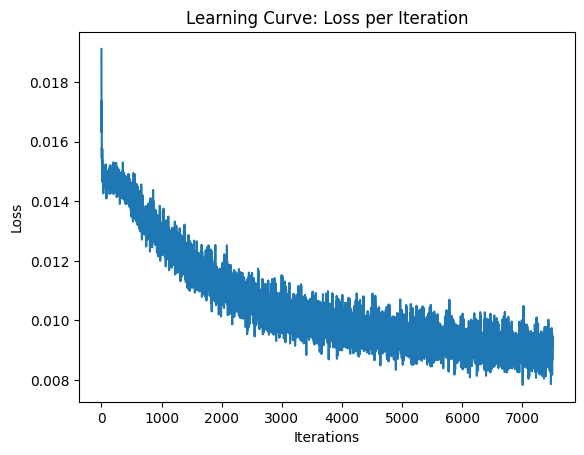

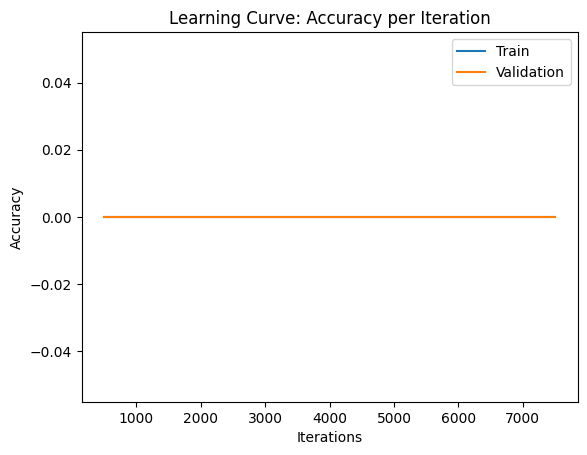

In [308]:
train_info = train(model, max_iters=7500)
plot_learning_curve(*train_info)

In [318]:

testinp = test4grams[10]
test_words = []
for ind in testinp:
    test_words.append(vocab_itos[ind])
print(testinp)
inp=torch.tensor(testinp[:3]).to(device).unsqueeze(0)

print(inp)

print(inp.shape)

modelout = model(inp)
print(modelout)
pred = torch.argmax(modelout, dim=-1)
print(pred)
pred_words = []
for ind in pred.cpu().detach().numpy()[0]:
    pred_words.append(vocab_itos[ind])
print(test_words)
print(pred_words)

[163 160 102  87]
tensor([[163, 160, 102]], device='cuda:0')
torch.Size([1, 3])
tensor([[[ 5.7434e-01,  9.1344e-01, -1.9267e-01, -1.0497e+00, -1.5330e+00,
          -4.3686e-01,  1.2916e+00,  2.1782e+00, -1.2140e+00, -2.0910e+00,
           6.3228e-01,  1.0990e+00, -1.0573e+00, -1.4547e+00,  1.5868e+00,
          -1.5364e+00, -1.2956e+00, -1.1035e+01, -9.5369e-01,  4.0861e-01,
          -9.3295e-01,  1.1862e+00, -2.1808e+00, -2.1143e+00,  1.7267e+00,
          -1.7262e+00,  1.3903e+00, -2.3586e+00, -1.3843e+00,  2.4526e-01,
           2.1599e+00, -3.8391e+00,  2.1229e+00,  9.2816e-01, -9.5768e-01,
           2.6682e-01, -6.6049e-01, -2.2838e+00, -3.2337e+00,  6.9910e-01,
           3.3635e+00,  2.8248e-01, -9.4194e-01,  9.9619e-01, -2.1502e+00,
          -2.3493e+00, -5.8553e-01,  1.3126e+00,  4.9987e-01, -9.6214e-01,
          -3.2599e+00, -4.6137e-01, -1.6060e+00, -2.0249e+00, -2.4066e-01,
          -1.1369e+00, -2.0758e+00, -2.5552e+00,  4.4359e+00,  1.8574e-01,
          -1.9420e+0

In [35]:
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 50 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits = model(X)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = Y.view(B*T)
            loss = F.cross_entropy(logits, targets)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [36]:
model = Transformer(len(vocab),  0,0, d_word=len(vocab), dims=len(vocab), n_heads=6,n_layers=10, n_pos=50
    )
m = model.to(device)
# print the number of parameters in the model
#print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')
print(next(m.parameters()).is_cuda)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

True
step 0: train loss 5.9674, val loss 5.9751


RuntimeError: Expected target size [64, 250], got [64, 50]